## Вспомогательный блок

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
(function(on) {
const e=$( "<a>Setup failed</a>" );
const ns="js_jupyter_suppress_warnings";
var cssrules=$("#"+ns);
if(!cssrules.length) cssrules = $("<style id='"+ns+"' type='text/css'>div.output_stderr { } </style>").appendTo("head");
e.click(function() {
    var s='Showing';  
    cssrules.empty()
    if(on) {
        s='Hiding';
        cssrules.append("div.output_stderr, div[data-mime-type*='.stderr'] { display:none; }");
    }
    e.text(s+' warnings (click to toggle)');
    on=!on;
}).click();
$(element).append(e);
})(true);

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

In [4]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdo

## Вспомогательные функции

##### Отрисовка многомерных распределений в 2-мерной плоскости

In [5]:
from sklearn.manifold import TSNE

def drawer(control, target):
    
    plotter = TSNE(n_components=2,
                   n_iter_without_progress=10,
                   n_iter = 10**3)
    
    n = control.__len__()
    
    plot_2d = plotter.fit_transform(np.r_[control, target])
    
    plt.figure(figsize = [7, 7])
    
    plt.scatter(plot_2d[:n, 0], plot_2d[:n, 1], label = 'control')
    plt.scatter(plot_2d[n:, 0], plot_2d[n:, 1], label = 'case')
    plt.title("Двумерная проекция распределений")
    
    plt.legend()
    
    plt.show()

#### Сэмплирование параметров распределений

In [6]:
from numpy.random import multivariate_normal as m_normal
from numpy.random import normal

In [7]:
def distribution_builder(dim = 30,
                         std_loc = 3,
                         mean_var = 2,
                         std_var = 1.2,
                         mixing = 0.5
                        ):
    
    """
    Задает мат. ожидание контрольного кластера и дисперсии для обоих кластеров
    
    dim - размерность данных
    std_loc - среднее значение дисперсии
    mean_var, std_var - ст. отклонение для генерируемых мат. ожиданий 
                        и дисперсий
    """

    if dim < 2 or mean_var < 0 or std_var < 0:
        raise ImportError
        
    # мат. ожидание генерируется в нуле, потом его уже сдвинут
    E1 = normal(0, mean_var, size = dim)
    
    # дисперсия генерируется, как матрица ковариации 2 сл. распределений
    
    cov1 = normal(std_loc, std_var, size = dim ** 2).reshape(-1, 2 * dim)
    cov2 = normal(std_loc, std_var, size = dim ** 2).reshape(-1, 2 * dim)
    
    D1 = np.cov(cov1, cov2)
    
    # мат. ожидание второго кластера - генерируется в следующей
    # функции, как сдвинутое мат. ожидание первого
    # дисперсия второго кластера генерируется аналогично первому:
    
    cov1 = normal(std_loc, std_var, size = dim ** 2).reshape(-1, 2 * dim)
    cov2 = normal(std_loc, std_var, size = dim ** 2).reshape(-1, 2 * dim)
    
    D2 = np.cov(cov1, cov2)
    
    mixing_shift = 1 * (np.abs(np.diag(D1)) + \
                    np.abs(np.diag(D2))) * (1 - mixing)
    
    E2 = E1 + mixing_shift
    
    return E1, D1, E2, D2

In [8]:
def run_tests(partitions, model, gen_func, E1, D1, E2, D2, size = 1e+4):
    
    results = []

    for part in partition:

        X_train, Y_train, X_test, Y_test = gen_func(E1, D1, E2, D2,
                                                    partition = part,
                                                    size = size)

        model.fit(X_train, Y_train)

        preds = model.predict_proba(X_test)[:, 1]

        fpr, tpr, steps = roc_curve(Y_test, preds)

        results.append([fpr, tpr, steps])
        
    return results

In [9]:
def draw_roc(results, proportions):
    
    """
    results consist of fpr, tpr and thresholds
    """
    fig, ax = plt.subplots(2, 3, figsize = [9, 7])
    
    for i in range(proportions.__len__()):
        
        fpr = results[i][0]
        tpr = results[i][1]
        prop = proportions[i]
        
        j = i // 3
        k = i % 3
        
        ax[j, k].plot(fpr, tpr)
        ax[j, k].set_title("proportion is: " + str(round(prop, 2)))
    
    plt.show()

# Эксперименты

In [10]:
E1, D1, E2, D2 = distribution_builder()

## Эксперимент 1:

Целевой (case) класс двухмодальный, при этом из мод одна совпадает с control, вторая - нет
Альтернатива (control) одномодальна

Ожидаемый вид RoC-кривой - TPP ассиметрия

In [11]:
def gen_1(E1 = E1, D1 = D1, E2 = E2, D2 = D2, 
          size = 1e+4,
          proportion = 1,
          partition = 0.5):
    
    train_size0 = int(size)
    train_size1 = int(size * proportion * partition)
    train_size2 = int(size * proportion * (1 - partition))
    
    X_train = np.r_[
        m_normal(E1, D1, size = train_size0 + train_size1),
        m_normal(E2, D2, size = train_size2)
    ]
    
    Y_train = np.r_[
        np.zeros(train_size0),
        np.ones(train_size1 + train_size2)
    ]
    
    test_size0 = int(0.1 * size)
    test_size1 = int(0.1 * size * proportion * partition)
    test_size2 = int(0.1 * size * (1 - partition) * proportion)
    
    X_test = np.r_[
        m_normal(E1, D1, size = test_size0 + test_size1),
        m_normal(E2, D2, size = test_size2)
    ]
    
    Y_test = np.r_[
        np.zeros(test_size0),
        np.ones(test_size1 + test_size2)
    ]
    
    return X_train, Y_train, X_test, Y_test

In [12]:
E1, D1, E2, D2 = distribution_builder(mixing = 0.3,
                                      dim = 10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

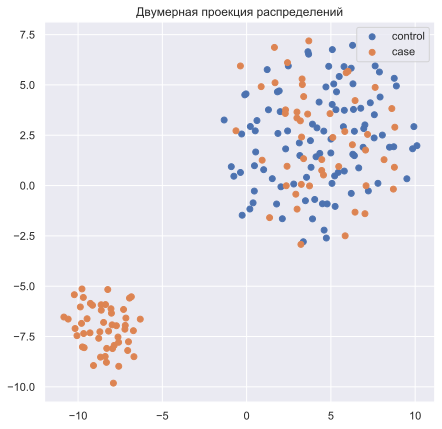

In [13]:
size = 100

sample, _, _, _ = gen_1(size = size)

drawer(sample[:size], sample[size:])

del(sample)

In [14]:
partition = np.arange(6) / 5

In [15]:
results_XGBC = run_tests(partition, XGBClassifier(), gen_1, E1, D1, E2, D2, size = 500)

[18:47:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

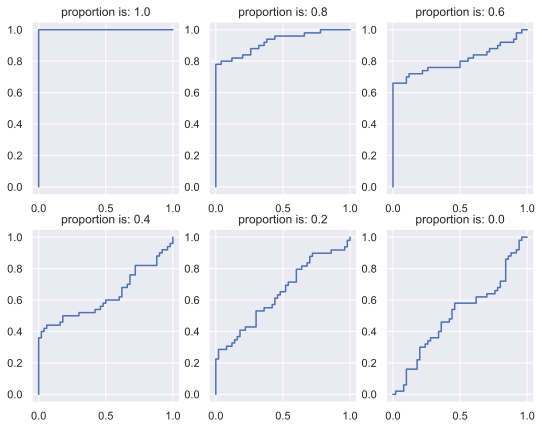

In [16]:
draw_roc(results_XGBC, 1 - partition)

In [17]:
results_SVC = run_tests(partition, SVC(probability = True), gen_1, E1, D1, E2, D2, size = 500)

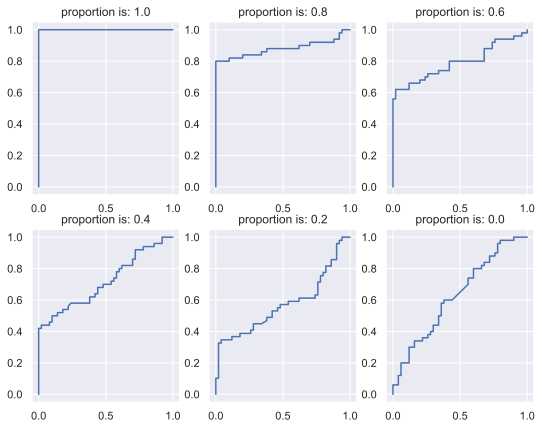

In [18]:
draw_roc(results_SVC, 1 - partition)

**Результат:** В зависимости от доли распознаваемых объектов (proportion в подписях графиков), изменяется доля распознаваемых данных, которые создают TPR-ассиметрию. После конца данной доли объектов начинается линейное увеличение долей и TPR, и FPR, которое продолжается до точки (1, 1)

## Эксперимент 2:

Целевой (case) класс одномодален

Альтернатива (control) двумодальна, состоит из 1 своей моды, и 1 моды из case

In [19]:
def gen_2(E1 = E1, D1 = D1, E2 = E2, D2 = D2, 
          size = 1e+4,
          proportion = 1,
          partition = 0.5):
    
    train_size0 = int(size)
    train_size1 = int(size * proportion * partition)
    train_size2 = int(size * proportion * (1 - partition))
    
    X_train = np.r_[
        m_normal(E1, D1, size = train_size0 + train_size1),
        m_normal(E2, D2, size = train_size2)
    ]
    
    Y_train = np.r_[
        np.ones(train_size0),
        np.zeros(train_size1 + train_size2)
    ]
    
    test_size0 = int(0.1 * size)
    test_size1 = int(0.1 * size * proportion * partition)
    test_size2 = int(0.1 * size * (1 - partition) * proportion)
    
    X_test = np.r_[
        m_normal(E1, D1, size = test_size0 + test_size1),
        m_normal(E2, D2, size = test_size2)
    ]
    
    Y_test = np.r_[
        np.ones(test_size0),
        np.zeros(test_size1 + test_size2)
    ]
    
    return X_train, Y_train, X_test, Y_test

In [20]:
E1, D1, E2, D2 = distribution_builder(mixing = 0.3, 
                                      dim = 10)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

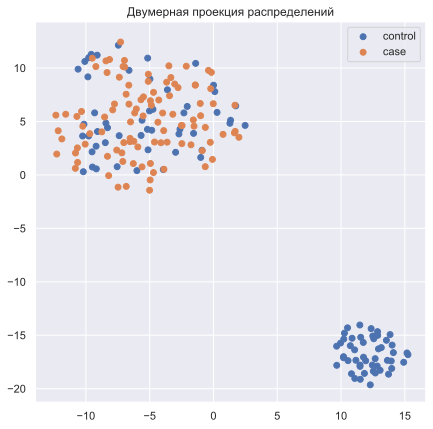

In [21]:
size = 100

sample, _, _, _ = gen_2(size = size)

drawer(sample[size:], sample[:size])

del(sample)

In [22]:
results_XGBC = run_tests(partition, XGBClassifier(), gen_2, E1, D1, E2, D2, size = 500)

[18:47:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:47:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

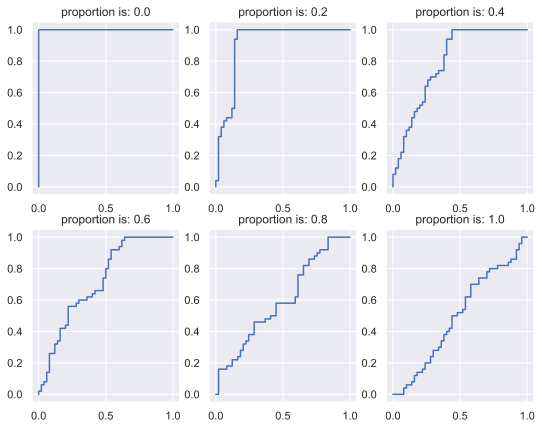

In [23]:
draw_roc(results_XGBC, partition)

In [24]:
results_SVC = run_tests(partition, SVC(probability = True), gen_2, E1, D1, E2, D2, size = 500)

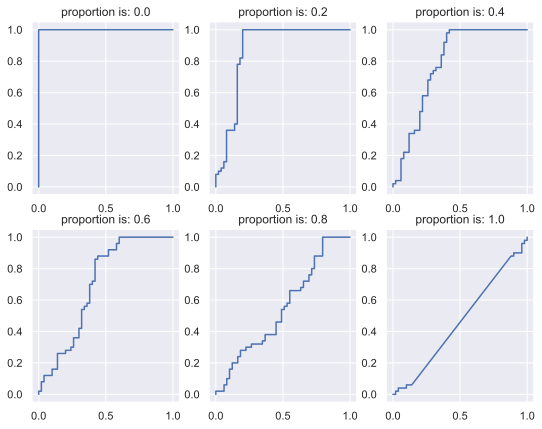

In [25]:
draw_roc(results_SVC, partition)

**Результат:** Proportion в данном случае описывает долю объектов, имеющих моду, совпадающую с модой case объектов.

Ситуация, обратная первому эксперименту. TNR - ассиметрия, и увеличение минимального значения FPR, при котором начинается полное распознавание объектов из target в зависимости от доли объектов с различными модами.

## Эксперимент 3:

Трехмодальная система:

Мода 1 - принадлежит case <br>
Мода 2 - принадлежит control <br>
Мода 3 - принадлежит обоим

In [26]:
def distribution_builder3(dim = 10,
                          mixing = 0.5,
                          std_loc = 3,
                          std_var = 1.2,
                          **kwargs):
    
    E1, D1, E2, D2 = distribution_builder(dim = dim, 
                                          std_loc = std_loc,
                                          std_var = std_var,
                                          mixing = mixing,
                                          **kwargs)
    
    cov1 = normal(std_loc, std_var, size = dim ** 2).reshape(-1, 2 * dim)
    cov2 = normal(std_loc, std_var, size = dim ** 2).reshape(-1, 2 * dim)
    
    D3 = np.cov(cov1, cov2)
    
    E3 = (E1 + E2) / 2
    slash = int(dim / 2)
    E3 += np.random.rand(dim) * -10
    
    return E1, D1, E2, D2, E3, D3


In [27]:
E1, D1, E2, D2, E3, D3 = distribution_builder3()

In [28]:
def gen_3(E1 = E1, D1 = D1, E2 = E2, D2 = D2, E3 = E3, D3 = D3,
          size = 1e+4,
          proportion = 1,
          partition1 = 0.5,
          partition2 = 0.5):
    
    train_size0 = int(size * partition1)
    train_size1 = int(size * (1 - partition1))
    train_size2 = int(size * proportion * partition2)
    train_size3 = int(size * proportion * (1 - partition2))
    
    X_train = np.r_[
        m_normal(E1, D1, size = train_size0),
        m_normal(E3, D3, size = train_size1 + train_size3),
        m_normal(E2, D2, size = train_size2)
    ]
    
    Y_train = np.r_[
        np.zeros(train_size0 + train_size1),
        np.ones(train_size2 + train_size3)
    ]
    
    test_size0 = int(0.1 * size * partition1)
    test_size1 = int(0.1 * size * (1 - partition1))
    test_size2 = int(0.1 * size * proportion * partition2)
    test_size3 = int(0.1 * size * proportion * (1 - partition2))
    
    X_test = np.r_[
        m_normal(E1, D1, size = test_size0),
        m_normal(E3, D3, size = test_size1 + test_size3),
        m_normal(E2, D2, size = test_size2)
    ]
    
    Y_test = np.r_[
        np.zeros(test_size0 + test_size1),
        np.ones(test_size2 + test_size3)
    ]
    
    return X_train, Y_train, X_test, Y_test

In [29]:
E1, D1, E2, D2, E3, D3 = distribution_builder3(dim = 10, mixing = 0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

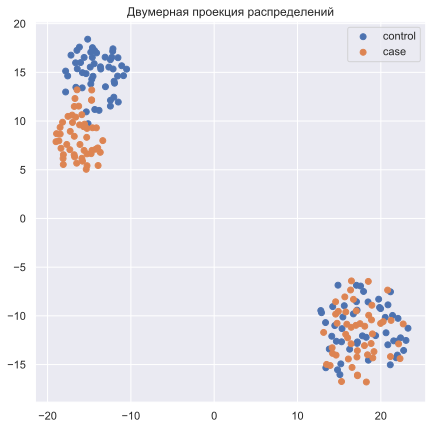

In [30]:
size = 100

sample, _, _, _ = gen_3(size = size)

drawer(sample[:size], sample[size:])

del(sample)

In [31]:
def run_tests_3(partitions, model, E1, D1, E2, D2, E3, D3, size = 1e+4):
    
    results = []

    for part in partition:

        X_train, Y_train, X_test, Y_test = gen_3(E1, D1, E2, D2, E3, D3,
                                                    partition1 = part,
                                                    partition2 = part,
                                                    size = size)

        model.fit(X_train, Y_train)

        preds = model.predict_proba(X_test)[:, 1]

        fpr, tpr, steps = roc_curve(Y_test, preds)

        results.append([fpr, tpr, steps])
        
    return results

In [32]:
results_XGBC = run_tests_3(partition, XGBClassifier(), E1, D1, E2, D2, E3, D3, size = 500)

[18:48:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

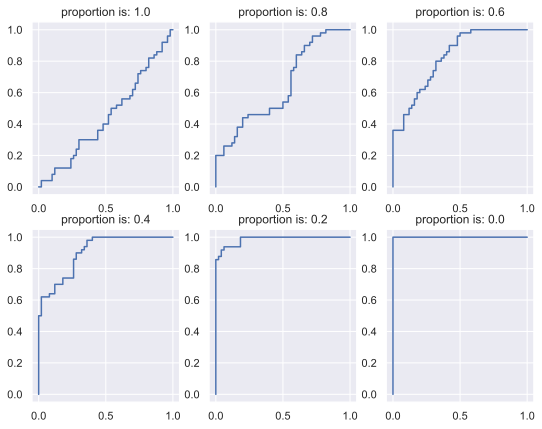

In [33]:
draw_roc(results_XGBC, 1 - partition)

In [34]:
results_SVC = run_tests_3(partition, SVC(probability = True), E1, D1, E2, D2, E3, D3, size = 500)

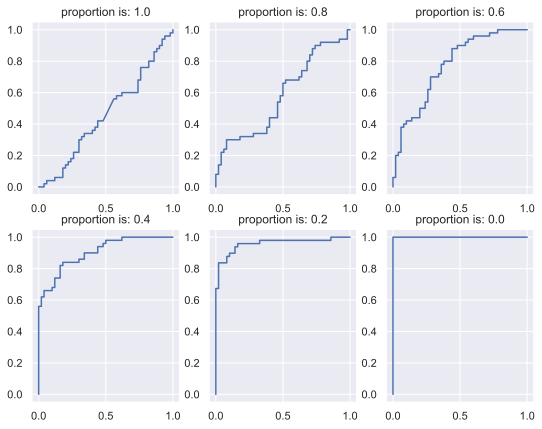

In [35]:
draw_roc(results_SVC, 1 - partition)

**Результат:** В данной ситуации proportion отвечает за долю объектов из каждого класса, которая принадлежит третьей, "общей", моде. 

Получается двусторонняя ассиметрия, линейно зависящая от доли безусловно распознаваемых объектов из каждого класса

## Эксперимент 4:

Одномодальные case/control с разной степенью погруженности друг в друга

In [36]:
def gen_4(E1 = E1, D1 = D1, E2 = E2, D2 = D2, 
          size = 1e+4,
          proportion = 1,
          mixing = 0.5):
    
    mixing_shift = 0.33 * (np.abs(np.diag(D1)) + \
                np.abs(np.diag(D2))) * (1 - mixing)
    
    E2_new = E1 + mixing_shift
    
    train_size0 = int(size)
    train_size1 = int(size * proportion)
    
    X_train = np.r_[
        m_normal(E1, D1, size = train_size0),
        m_normal(E2_new, D2, size = train_size1)
    ]
    
    Y_train = np.r_[
        np.zeros(train_size0),
        np.ones(train_size1)
    ]
    
    test_size0 = int(0.1 * size)
    test_size1 = int(0.1 * size * proportion)
    
    X_test = np.r_[
        m_normal(E1, D1, size = test_size0),
        m_normal(E2_new, D2, size = test_size1)
    ]
    
    Y_test = np.r_[
        np.zeros(test_size0),
        np.ones(test_size1)
    ]
    
    return X_train, Y_train, X_test, Y_test

### Примеры того, как выглядят распределения

In [37]:
from sklearn.manifold import TSNE

def drawer_4(control, target, mix):
    
    plotter = TSNE(n_components=2,
                   n_iter_without_progress=10,
                   n_iter = 10**3)
    
    n = control.__len__()
    
    plot_2d = plotter.fit_transform(np.r_[control, target])
    
    plt.figure(figsize = [7, 7])
    
    plt.scatter(plot_2d[:n, 0], plot_2d[:n, 1], label = 'control')
    plt.scatter(plot_2d[n:, 0], plot_2d[n:, 1], label = 'case')
    plt.title("Двумерная проекция распределений, mixing = " + str(mix))
    
    plt.legend()
    
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

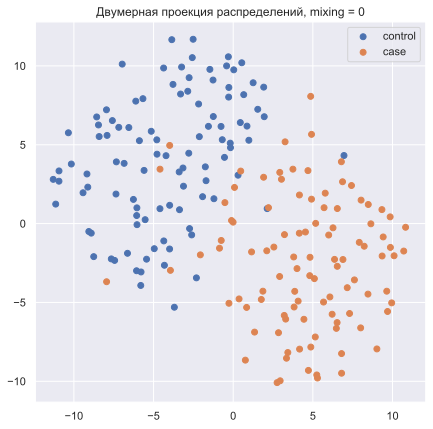

In [38]:
E1, D1, E2, D2 = distribution_builder(dim = 10)
size = 100

sample, _, _, _ = gen_4(size = size, mixing = 0)

drawer_4(sample[:size], sample[size:], 0)

del(sample)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

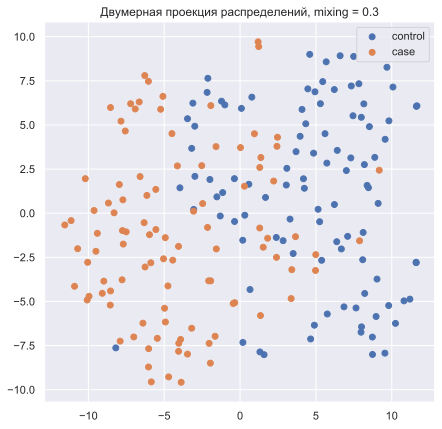

In [39]:
E1, D1, E2, D2 = distribution_builder(dim = 10)
size = 100

sample, _, _, _ = gen_4(size = size, mixing = 0.3)

drawer_4(sample[:size], sample[size:], 0.3)

del(sample)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

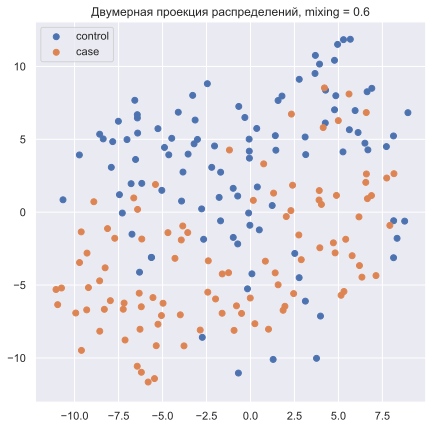

In [40]:
E1, D1, E2, D2 = distribution_builder(dim = 10)
size = 100

sample, _, _, _ = gen_4(size = size, mixing = 0.6)

drawer_4(sample[:size], sample[size:], 0.6)

del(sample)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
 

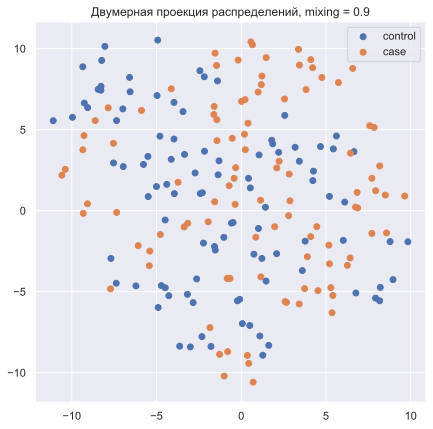

In [41]:
E1, D1, E2, D2 = distribution_builder(dim = 10)
size = 100

sample, _, _, _ = gen_4(size = size, mixing = 0.9)

drawer_4(sample[:size], sample[size:], 0.9)

del(sample)

In [42]:
mixings = (np.arange(9) + 1) / 10

In [43]:
def run_tests_4(mixings, model, E1, D1, E2, D2, size = 1e+4):
    
    results = []

    for part in mixings:

        X_train, Y_train, X_test, Y_test = gen_4(E1, D1, E2, D2,
                                                    size = size,
                                                    mixing = part)

        model.fit(X_train, Y_train)

        preds = model.predict_proba(X_test)[:, 1]

        fpr, tpr, steps = roc_curve(Y_test, preds)

        results.append([fpr, tpr, steps])
        
    return results

In [44]:
def draw_roc_4(results, mixings):
    
    """
    results consist of fpr, tpr and thresholds
    """
    fig, ax = plt.subplots(3, 3, figsize = [9, 11])
    
    for i in range(mixings.__len__()):
        
        fpr = results[i][0]
        tpr = results[i][1]
        prop = mixings[i]
        
        j = i // 3
        k = i % 3
        
        ax[j, k].plot(fpr, tpr)
        ax[j, k].set_title("mixing is: " + str(round(prop, 2)))
    
    plt.show()

In [45]:
E1, D1, E2, D2 = distribution_builder(dim = 10)

In [46]:
results_XGBC = run_tests_4(mixings, XGBClassifier(), E1, D1, E2, D2, size = 500)

[18:48:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:48:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

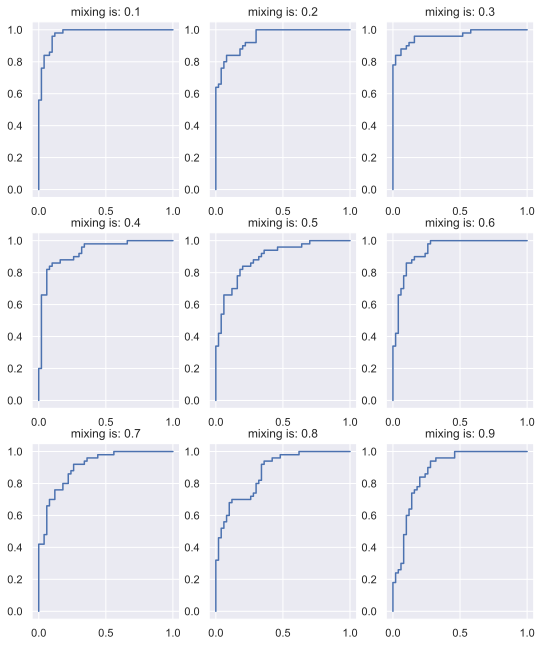

In [47]:
draw_roc_4(results_XGBC, mixings)

**Результат:** Mixing в данном случае отвечает за степень погруженности классов друг в друга. Чем он больше - тем ближе мат. ожидания для обоих мод нормальных распределений.

В результате была получена такая же ситуация, как в эксперименте 3 - двусторонняя ассиметрия, вызванная наличием "непересекающихся" частей для каждой из мод.